<a href="https://colab.research.google.com/github/OlamidotunT/Big-Data-Project/blob/main/BBC_News_Article_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import zipfile
import pandas as pd
import os

uploaded_zip_path = "/content/bbc-fulltext.zip"
extract_path = "/mnt/data/bbc"

with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

data = []
bbc_text_path = os.path.join(extract_path, "bbc")
for category_folder in os.listdir(bbc_text_path):
    category_path = os.path.join(bbc_text_path, category_folder)
    if os.path.isdir(category_path):
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            with open(file_path, "r", encoding="latin1") as f:
                text = f.read()
                data.append({"category": category_folder, "text": text})

df_bbc = pd.DataFrame(data)
df_bbc.head()

,category,text
0,tech,Apple makes blogs reveal sources\n\nApple has ...
1,tech,Gamers snap up new Sony PSP\n\nGamers have bou...
2,tech,Consumers 'snub portable video'\n\nConsumers w...
3,tech,UK broadband gets speed injection\n\nBroadband...
4,tech,Sun offers processing by the hour\n\nSun Micro...


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Overview of categories
print("Unique top-level categories:", df_bbc['category'].unique())
print("\nCategory counts:")
print(df_bbc['category'].value_counts())


Unique top-level categories: ['tech' 'business' 'politics' 'entertainment' 'sport']

Category counts:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


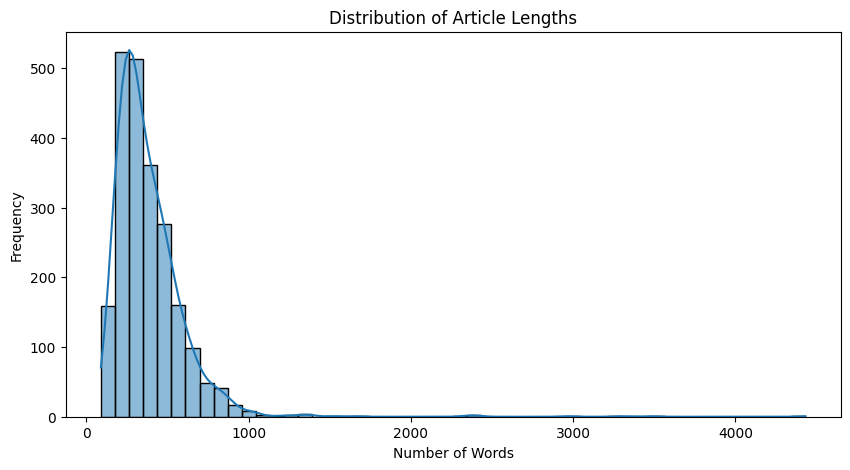

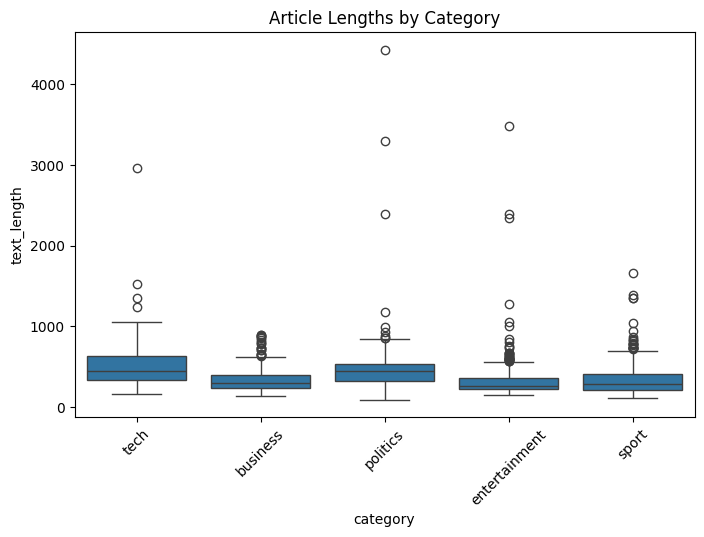

In [5]:
# Article lengths
df_bbc['text_length'] = df_bbc['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df_bbc['text_length'], bins=50, kde=True)
plt.title("Distribution of Article Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Average length per category
plt.figure(figsize=(8, 5))
sns.boxplot(x='category', y='text_length', data=df_bbc)
plt.title("Article Lengths by Category")
plt.xticks(rotation=45)
plt.show()


In [6]:
def auto_label_subcategory(text, category):
    text = text.lower()

    if category == "sport":
        if any(k in text for k in ["football", "premier league", "soccer"]):
            return "football"
        elif any(k in text for k in ["olympic", "athletics"]):
            return "olympics"
        elif "rugby" in text:
            return "rugby"
        elif "tennis" in text:
            return "tennis"
        elif "boxing" in text:
            return "boxing"
        elif "cricket" in text:
            return "cricket"
        elif "basketball" in text:
            return "basketball"
        else:
            return "othersport"

    elif category == "business":
        if any(k in text for k in ["bank", "banking", "loan", "finance"]):
            return "banking"
        elif any(k in text for k in ["company", "corporate", "business"]):
            return "company"
        elif any(k in text for k in ["economy", "economic", "inflation", "gdp"]):
            return "economy"
        elif any(k in text for k in ["investment", "invest", "fund", "portfolio"]):
            return "investment"
        elif any(k in text for k in ["merger", "acquisition", "takeover"]):
            return "mergers"
        elif any(k in text for k in ["regulation", "law", "compliance"]):
            return "regulation"
        elif any(k in text for k in ["startup", "start-up", "entrepreneur"]):
            return "startup"
        elif any(k in text for k in ["stock", "shares", "market", "trading"]):
            return "stock"
        elif any(k in text for k in ["tax", "taxation"]):
            return "tax"
        else:
            return "otherbusiness"

    elif category == "entertainment":
        if any(k in text for k in ["art", "painting", "gallery"]):
            return "art"
        elif any(k in text for k in ["film", "movie", "cinema"]):
            return "cinema"
        elif any(k in text for k in ["festival", "concert", "event"]):
            return "festival"
        elif any(k in text for k in ["book", "novel", "literature"]):
            return "literature"
        elif any(k in text for k in ["music", "album", "band", "concert"]):
            return "music"
        elif any(k in text for k in ["celebrity", "star", "personality"]):
            return "personality"
        elif any(k in text for k in ["tv", "series", "television"]):
            return "television"
        else:
            return "otherentertainment"

    elif category == "politics":
        if any(k in text for k in ["domestic", "local", "policy", "law"]):
            return "domestic"
        elif any(k in text for k in ["education"]):
            return "education"
        elif any(k in text for k in ["election", "vote", "ballot"]):
            return "elections"
        elif any(k in text for k in ["government", "minister", "cabinet"]):
            return "government"
        elif any(k in text for k in ["health", "nhs", "medical"]):
            return "health"
        elif any(k in text for k in ["international", "foreign", "united nations", "UN"]):
            return "international"
        elif any(k in text for k in ["law", "legal"]):
            return "law"
        elif any(k in text for k in ["scandal", "resignation", "controversy"]):
            return "scandal"
        elif any(k in text for k in ["security", "defense", "defence"]):
            return "security"
        else:
            return "otherpolitics"

    elif category == "tech":
        if any(k in text for k in ["ai", "artificial intelligence", "machine learning", "deep learning"]):
            return "ai"
        elif any(k in text for k in ["business", "startup", "tech company"]):
            return "business"
        elif any(k in text for k in ["phone", "gadget", "device", "consumer electronics"]):
            return "consumer"
        elif any(k in text for k in ["internet", "browser", "web", "google", "search"]):
            return "internet"
        elif any(k in text for k in ["security", "virus", "hack", "malware"]):
            return "security"
        elif any(k in text for k in ["software", "app", "program", "microsoft", "operating system"]):
            return "software"
        else:
            return "othertech"

    else:
        return None






In [7]:
df_bbc['subcategory'] = df_bbc.apply(lambda row: auto_label_subcategory(row['text'], row['category']), axis=1)

subcategory_counts = df_bbc.groupby(['category', 'subcategory']).size().sort_values(ascending=False)

print(subcategory_counts)


category       subcategory  
tech           ai               401
entertainment  art              285
sport          othersport       240
politics       domestic         231
business       banking          228
               company          180
sport          football          87
               olympics          86
politics       elections         83
sport          rugby             61
entertainment  cinema            55
politics       government        50
business       economy           48
politics       education         36
sport          tennis            35
business       stock             19
               investment        19
entertainment  music             18
politics       otherpolitics     11
business       otherbusiness     10
entertainment  festival          10
               personality        8
               television         6
               literature         4
business       regulation         3
politics       international      3
business       mergers            2

In [8]:
for cat in df_bbc['category'].unique():
    print(f"Category: {cat}")
    print(df_bbc[df_bbc['category'] == cat].sample(3)[['text', 'subcategory']])
    print()


Category: tech
                                                  text subcategory
276  Gadget market 'to grow in 2005'\n\nThe explosi...          ai
139  Concern over RFID tags\n\nConsumers are very c...          ai
275  Ink helps drive democracy in Asia\n\nThe Kyrgy...          ai

Category: business
                                                  text subcategory
729  Cairn Energy in Indian gas find\n\nShares in C...     company
581  Arsenal 'may seek full share listing'\n\nArsen...     banking
570  China suspends 26 power projects\n\nChina has ...     economy

Category: politics
                                                   text    subcategory
1005  Ex-PM Lord Callaghan dies aged 92\n\nFormer La...      elections
1244  Borders rail link campaign rally\n\nCampaigner...  otherpolitics
1062  Police urge pub closure power\n\nNew powers ar...       domestic

Category: entertainment
                                                   text subcategory
1429  Potter director signs Warn

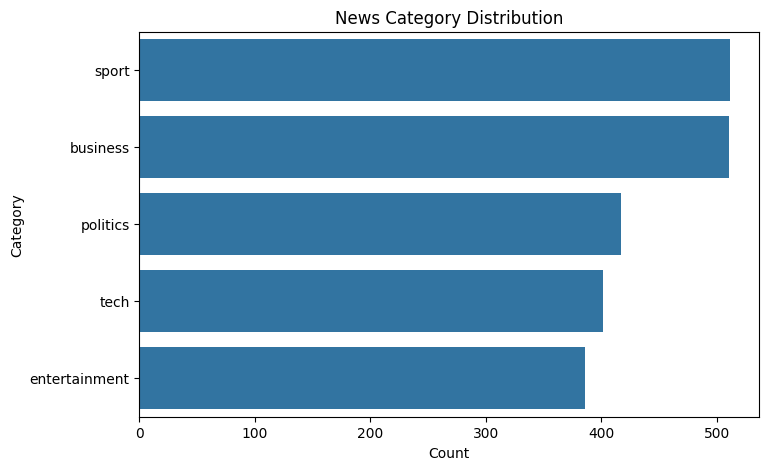

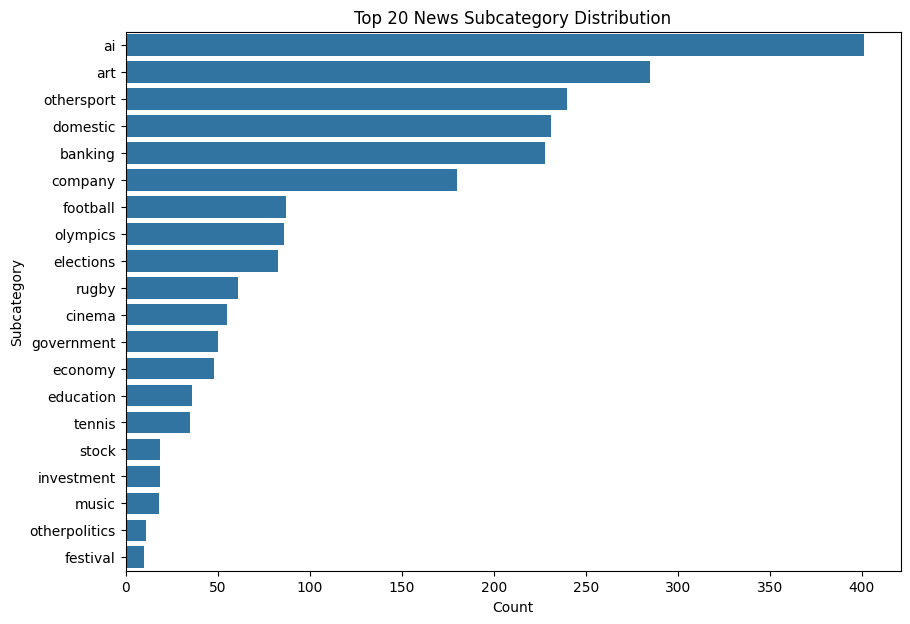

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot category counts
plt.figure(figsize=(8,5))
sns.countplot(data=df_bbc, y='category', order=df_bbc['category'].value_counts().index)
plt.title('News Category Distribution')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# Plot top 20 subcategory counts
top_subcats = df_bbc['subcategory'].value_counts().head(20).index
plt.figure(figsize=(10,7))
sns.countplot(data=df_bbc[df_bbc['subcategory'].isin(top_subcats)], y='subcategory', order=top_subcats)
plt.title('Top 20 News Subcategory Distribution')
plt.xlabel('Count')
plt.ylabel('Subcategory')
plt.show()


In [10]:
# Create a new column with article text length
df_bbc['text_length'] = df_bbc['text'].apply(len)

# Average article length by category
avg_len_cat = df_bbc.groupby('category')['text_length'].mean().sort_values()
print("Average article length by category:\n", avg_len_cat)

# Average article length by top 10 subcategories
top_10_subcat = df_bbc['subcategory'].value_counts().head(10).index
avg_len_subcat = df_bbc[df_bbc['subcategory'].isin(top_10_subcat)].groupby('subcategory')['text_length'].mean()
print("\nAverage article length by top 10 subcategories:\n", avg_len_subcat)


Average article length by category:
 category
sport            1897.487280
entertainment    1929.339378
business         1987.664706
politics         2685.007194
tech             2976.775561
Name: text_length, dtype: float64

Average article length by top 10 subcategories:
 subcategory
ai            2976.775561
art           2082.364912
banking       2153.574561
company       1872.811111
domestic      3023.878788
elections     2461.301205
football      2191.873563
olympics      1950.732558
othersport    1698.854167
rugby         2236.934426
Name: text_length, dtype: float64


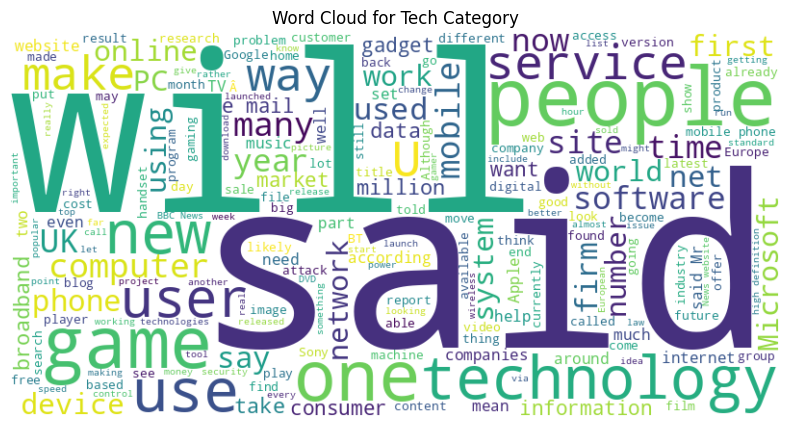

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word cloud for 'tech' category
tech_text = " ".join(df_bbc[df_bbc['category']=='tech']['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tech_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Tech Category")
plt.show()



Classification Report:
               precision    recall  f1-score   support

          ai       0.95      1.00      0.97        97
         art       0.99      0.99      0.99        74
     banking       0.98      0.92      0.95        64
    domestic       0.98      0.96      0.97        57
  othersport       1.00      1.00      1.00        55

    accuracy                           0.98       347
   macro avg       0.98      0.97      0.98       347
weighted avg       0.98      0.98      0.98       347



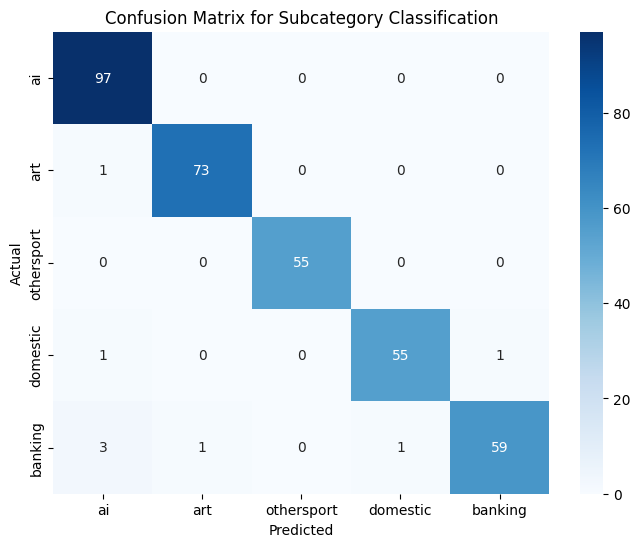

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Select top 5 subcategories to keep classification manageable
selected_subcats = df_bbc['subcategory'].value_counts().nlargest(5).index
df_model = df_bbc[df_bbc['subcategory'].isin(selected_subcats)].copy()

X = df_model['text']
y = df_model['subcategory']

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_vect = vectorizer.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.25, random_state=42)

# Train Logistic Regression classifier
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=selected_subcats)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=selected_subcats, yticklabels=selected_subcats, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Subcategory Classification')
plt.show()


In [13]:
import spacy

# Load spaCy English model
nlp = spacy.load('en_core_web_sm')

def extract_named_entities_with_job(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ == 'PERSON':

            if any(word in text.lower() for word in ['minister', 'mp', 'politician', 'government']):
                job = 'Politician'
            elif any(word in text.lower() for word in ['actor', 'actress', 'film', 'tv', 'television', 'director']):
                job = 'TV/Film Personality'
            elif any(word in text.lower() for word in ['singer', 'musician', 'band', 'music']):
                job = 'Musician'
            else:
                job = 'Unknown'

            entities.append({'name': ent.text, 'job': job})
    return entities

df_bbc['named_entities'] = df_bbc['text'].apply(extract_named_entities_with_job)

print(df_bbc[['text', 'named_entities']].head())


                                                text  \
0  Apple makes blogs reveal sources\n\nApple has ...   
1  Gamers snap up new Sony PSP\n\nGamers have bou...   
2  Consumers 'snub portable video'\n\nConsumers w...   
3  UK broadband gets speed injection\n\nBroadband...   
4  Sun offers processing by the hour\n\nSun Micro...   

                                      named_entities  
0  [{'name': 'James Kleinberg', 'job': 'Politicia...  
1                                                 []  
2  [{'name': 'Ian Fogg', 'job': 'Politician'}, {'...  
3  [{'name': 'Chris Stening', 'job': 'Politician'...  
4  [{'name': 'Jonathan Schwartz', 'job': 'Politic...  


In [14]:
# Flatten the list of entities and extract all job titles
all_jobs = [entity['job'] for entities_list in df_bbc['named_entities'] for entity in entities_list]

# Get unique jobs and their counts
from collections import Counter
job_counts = Counter(all_jobs)

print("Unique job labels and their counts:")
for job, count in job_counts.items():
    print(f"{job}: {count}")


Unique job labels and their counts:
Politician: 18494
TV/Film Personality: 1234
Unknown: 1076
Musician: 311


In [15]:
import re

def extract_april_sentences(text):
    # Extract sentences that mention 'April' (case insensitive)
    sentences = re.findall(r'([^.]*April[^.]*\.)', text, flags=re.IGNORECASE)
    return ' '.join(sentences)

df_bbc['april_events'] = df_bbc['text'].apply(extract_april_sentences)

# Filter to only rows that contain April events
april_df = df_bbc[df_bbc['april_events'] != '']

print(april_df[['text', 'april_events']].head())


                                                  text  \
12   T-Mobile bets on 'pocket office'\n\nT-Mobile h...   
49   US peer-to-peer pirates convicted\n\nThe first...   
60   US peer-to-peer pirates convicted\n\nThe first...   
184  Learning to love broadband\n\nWe are reaching ...   
206  Virus poses as Christmas e-mail\n\nSecurity fi...   

                                          april_events  
12    The service, which has been developed with So...  
49    The two men are due to be sentenced on 29 April.  
60    The two men are due to be sentenced on 29 April.  
184  \n\nAccording to Ofcom there were almost four ...  
206   The original Zafi virus appeared in April thi...  


In [16]:
# Extract Unknown entities
unknown_entities = [entity for entities_list in df_bbc['named_entities'] for entity in entities_list if entity['job'] == 'Unknown']

print(f"Number of Unknown entities: {len(unknown_entities)}")

# Show a sample to understand what kind of data they hold
for i, entity in enumerate(unknown_entities[:10]):
    print(f"{i+1}. Name: {entity['name']}, Context (if any): {entity.get('context', 'N/A')}")


Number of Unknown entities: 1076
1. Name: Jeremy Jaynes, Context (if any): N/A
2. Name: Jessica DeGroot, Context (if any): N/A
3. Name: Richard Rutkowski, Context (if any): N/A
4. Name: Russell McGuire, Context (if any): N/A
5. Name: Jerry Kilgore, Context (if any): N/A
6. Name: David Oblon, Context (if any): N/A
7. Name: Jeremy Jaynes, Context (if any): N/A
8. Name: Jessica DeGroot, Context (if any): N/A
9. Name: Richard Rutkowski, Context (if any): N/A
10. Name: Russell McGuire, Context (if any): N/A


In [17]:
with open("Timothy_Egbejinmi.txt", "w") as f:
    f.write("This file confirms that the repository belongs to Timothy Egbejinmi.")
